In [2]:
#==============================================================================
# Spam Detection using Stacking Ensemble
# Base Models: MultinomialNB + Gradient Boosting
# Meta model: Logistic Regression
#===============================================================================


In [33]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier,StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,RocCurveDisplay
import pickle

In [5]:
#=================================================================================
# Load Dataset
#=================================================================================
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\mail_data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Handle nulls
mail_data = df.where(pd.notnull(df),'')


In [8]:
# Encode target
mail_data.loc[mail_data["Category"]=="spam","Category"]=0
mail_data.loc[mail_data["Category"]=="ham","Category"]=1

In [9]:
# features and Labels
x = mail_data["Message"]
y = mail_data["Category"].astype("int")

In [10]:
# Split Train and test Data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [11]:
# Test Feature Extraction (TF-IDF)
feature_extraction = TfidfVectorizer(min_df=1,stop_words="english",lowercase=True)
x_train_features = feature_extraction.fit_transform(x_train)
x_test_features = feature_extraction.transform(x_test)

In [27]:
#======================================================================================
# Base Models
#======================================================================================
#Model 1:- Gradient Boosting
param_grid = {
    "n_estimators":[200,250,300,350,400],
    "max_depth":[3,4,5,6,7],
    "learning_rate":[0.1,0.5,0.01,0.05]
}
gd = GradientBoostingClassifier(random_state=42)
grid_gd = RandomizedSearchCV(gd,param_grid,cv=5,n_jobs=-1,n_iter=20,scoring="roc_auc")
grid_gd.fit(x_train_features,y_train)
best_gd = grid_gd.best_estimator_

In [28]:
# Model 2:- Naive Bayes
model = MultinomialNB()
best_nb = model.fit(x_train_features,y_train)


In [29]:
# Build Stacking Ensemble
base_model = [
    ("nb",best_nb),
    ("gd",best_gd)
]
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression(max_iter=1000)
stack = StackingClassifier(
    estimators=base_model,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)
stack.fit(x_train_features, y_train)

StackingClassifier(cv=5,
                   estimators=[('nb', MultinomialNB()),
                               ('gd',
                                GradientBoostingClassifier(learning_rate=0.5,
                                                           max_depth=6,
                                                           n_estimators=350,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                   passthrough=True)

In [30]:
# Model Evaluation
y_pred = stack.predict(x_test_features)
y_proba = stack.predict_proba(x_test_features)[:, 1]
print("\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))



--- Model Evaluation ---
Test Accuracy: 0.9901
ROC-AUC Score: 0.9919

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       149
           1       0.99      1.00      0.99       966

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115

[[138  11]
 [  0 966]]


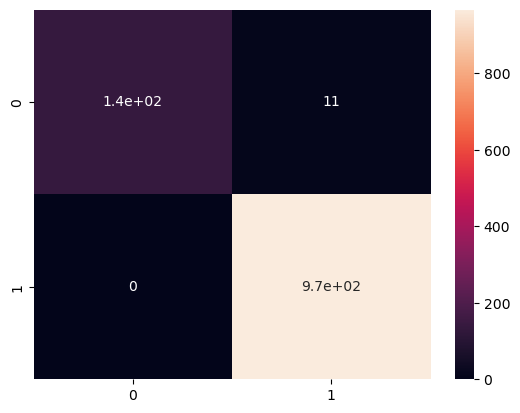

In [31]:
#===============================================================================
# visualization
#===============================================================================
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)
plt.show()

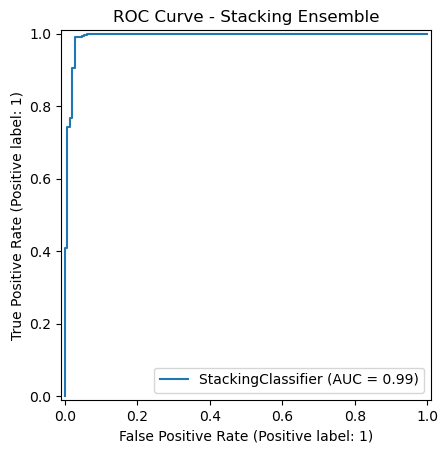

In [34]:
# Roc Curve
RocCurveDisplay.from_estimator(stack, x_test_features, y_test)
plt.title("ROC Curve - Stacking Ensemble")
plt.show()


In [36]:
# Save Model and Vectorizer
model = "spam_model.sav"
pickle.dump(stack,open(model,"wb"))
pickle.dump(feature_extraction,open("tfidf_vectorizer.pkl","wb"))